# Gemini 3 Pro Image Generation API Response Structure Test

This notebook sends a prompt to the Gemini 3 Pro image generation API and displays the full JSON response structure, truncating long base64 strings to 15 characters. All key names and values are shown for inspection.

## 1. Set Up Temporary Working Directory
We'll use Python's `tempfile` and `os` modules to create and switch to a temporary directory for this notebook's workspace.

In [2]:
import tempfile
import os

# Create a temporary directory and switch to it
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
print(f"Working directory: {temp_dir}")

Working directory: /tmp/tmp1c5ktkqv


In [3]:
import requests
import json



In [4]:
from getpass import getpass

# Prompt for OpenRouter API key securely
OPENROUTER_API_KEY = getpass("Enter your OpenRouter API key: ")

# Update headers with the new API key
headers = {
    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
    "Content-Type": "application/json"
}

print("API key set successfully!")

API key set successfully!


In [7]:
MODEL_NAME = "google/gemini-3-pro-image-preview"

In [5]:

prompt = "Make an image of a small red circle on a plain white background. Just return one image."


In [8]:
payload = {
    "model": MODEL_NAME,
    "messages": [
        {"role": "user", "content": prompt}
    ],
    "generationConfig": {
        "responseModalities": ["IMAGE"],
        "imageConfig": {
            "aspectRatio": "1:1",      # or "16:9", "4:3", etc.
            "imageSize": "SMALL"       # or "MEDIUM", "LARGE", "2K", etc.
        }
    }
}

In [9]:
print(json.dumps(payload, indent=2))

{
  "model": "google/gemini-3-pro-image-preview",
  "messages": [
    {
      "role": "user",
      "content": "Make an image of a small red circle on a plain white background. Just return one image."
    }
  ],
  "generationConfig": {
    "responseModalities": [
      "IMAGE"
    ],
    "imageConfig": {
      "aspectRatio": "1:1",
      "imageSize": "SMALL"
    }
  }
}


### Prompt for Image Generation

Make an image of a small red circle on a plain white background.

In [11]:

OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
response = requests.post(OPENROUTER_BASE_URL, headers=headers, json=payload)
print(f"Status Code: {response.status_code}")


Status Code: 200


In [12]:
# Dump the raw response text into a .txt file in the temp folder
with open(os.path.join('/workspaces/open-webui/temp/response.txt'), 'w') as f:
    f.write(response.text)
print(f"Response saved to: {'/workspaces/open-webui/temp/response.txt'}")

Response saved to: /workspaces/open-webui/temp/response.txt


In [13]:
def truncate_base64_strings(obj, max_length=15):
    """Traverse the object tree and truncate any string values over max_length characters."""
    if isinstance(obj, dict):
        return {k: truncate_base64_strings(v, max_length) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [truncate_base64_strings(i, max_length) for i in obj]
    elif isinstance(obj, str):
        if len(obj) > max_length:
            return obj[:max_length] + '...'
        return obj
    else:
        return obj

In [14]:
truncated = truncate_base64_strings(response.json(), max_length=150)
print(json.dumps(truncated, indent=2))


{
  "id": "gen-1765151153-kT9BwnOtTotuc23Mfhzi",
  "provider": "Google AI Studio",
  "model": "google/gemini-3-pro-image-preview",
  "object": "chat.completion",
  "created": 1765151153,
  "choices": [
    {
      "logprobs": null,
      "finish_reason": "stop",
      "native_finish_reason": "STOP",
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "",
        "refusal": null,
        "reasoning": "**Constructing a Simple Image**\n\nI'm now focused on the fundamental elements: a red circle against a white backdrop, perfectly centered. Details are b...",
        "reasoning_details": [
          {
            "format": "google-gemini-v1",
            "index": 0,
            "type": "reasoning.text",
            "text": "**Constructing a Simple Image**\n\nI'm now focused on the fundamental elements: a red circle against a white backdrop, perfectly centered. Details are b..."
          },
          {
            "format": "google-gemini-v1",
            "

In [15]:
# Output truncated version to the same temp/ folder in this repo
with open('/workspaces/open-webui/temp/response_truncated.json', 'w') as f:
    json.dump(truncated, f, indent=2)
print(f"Truncated response saved to: /workspaces/open-webui/temp/response_truncated.json")

Truncated response saved to: /workspaces/open-webui/temp/response_truncated.json


In [19]:
# Recursively walk the response object to find all base64 image strings
import base64
from PIL import Image
import io
import re

def find_base64_images(obj):
    images = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            # Look for image_url dicts with a 'url' field
            if k == 'image_url' and isinstance(v, dict) and 'url' in v:
                match = re.match(r'data:image/\w+;base64,(.*)', v['url'])
                if match:
                    images.append(match.group(1))
            else:
                images.extend(find_base64_images(v))
    elif isinstance(obj, list):
        for item in obj:
            images.extend(find_base64_images(item))
    return images

# Load the full response object
full_response = response.json()
image_strings = find_base64_images(full_response)
print(f"Found {len(image_strings)} images in the response.")

Found 2 images in the response.


In [20]:
print(f"Found {len(image_strings)} images in the response.")

Found 2 images in the response.


In [22]:
print(f"Image 1 is {len(image_strings[0])} characters long.")
print(f"Image 2 is {len(image_strings[1])} characters long.")

Image 1 is 712860 characters long.
Image 2 is 712156 characters long.


In [23]:

# Compare base64 strings directly
if len(image_strings) == 2:
    identical_base64 = image_strings[0] == image_strings[1]
    print(f"Base64 identical: {identical_base64}")
    # Compare visually using Pillow
    img1 = Image.open(io.BytesIO(base64.b64decode(image_strings[0])))
    img2 = Image.open(io.BytesIO(base64.b64decode(image_strings[1])))
    identical_pixels = list(img1.getdata()) == list(img2.getdata())
    print(f"Images visually identical: {identical_pixels}")
    # Optionally, compare trimmed base64 (remove trailing padding)
    trimmed_identical = image_strings[0].rstrip('=') == image_strings[1].rstrip('=')
    print(f"Trimmed base64 identical: {trimmed_identical}")
else:
    print(f"Found {len(image_strings)} images, not 2.")

Base64 identical: False
Images visually identical: False
Trimmed base64 identical: False
Images visually identical: False
Trimmed base64 identical: False


Difference array shape: (768, 1408, 3)
Max pixel difference: 7
Mean pixel difference: 0.59
Nonzero pixel count: 1542669


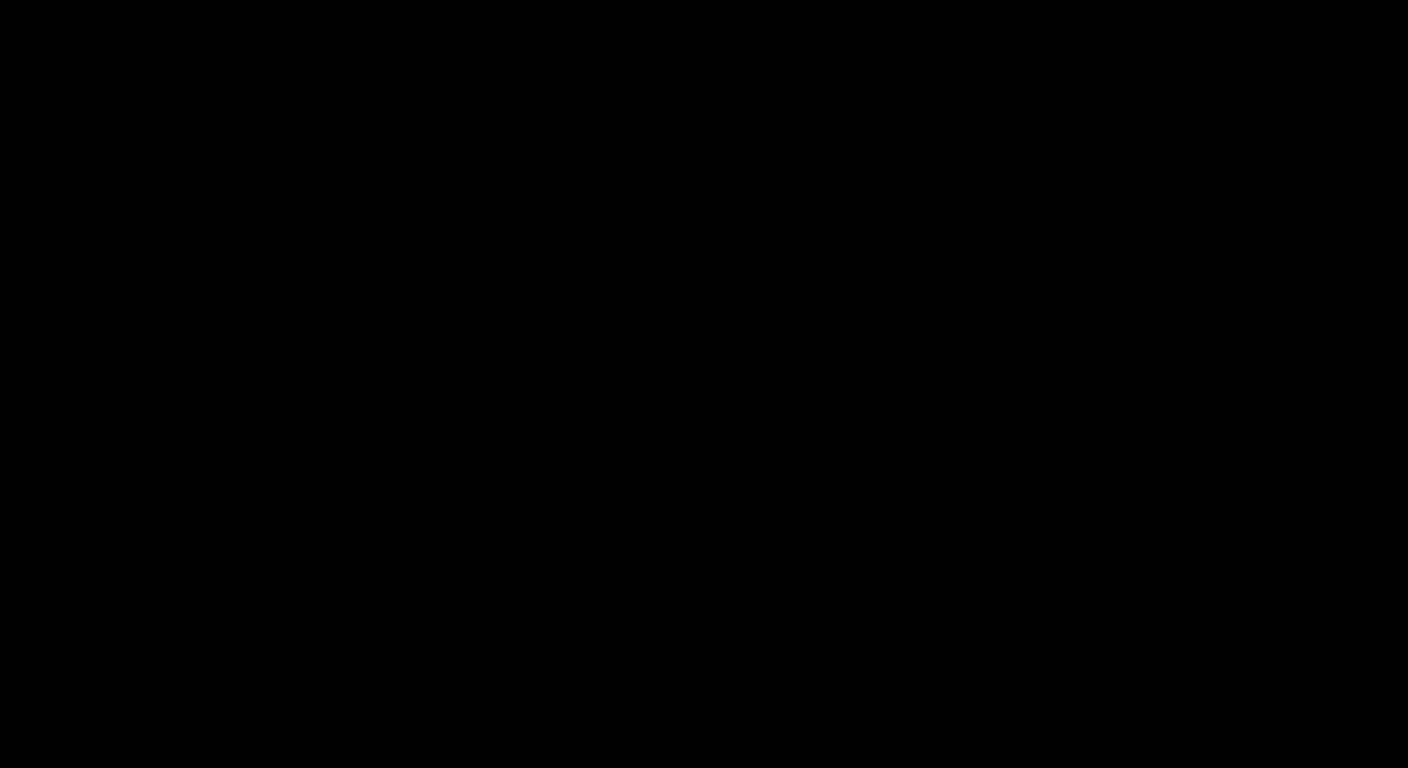

Image 1 format: JPEG, mode: RGB, size: (1408, 768)
Image 2 format: JPEG, mode: RGB, size: (1408, 768)


In [24]:
# Quantify visual difference between two images
from PIL import ImageChops
import numpy as np

img1 = Image.open(io.BytesIO(base64.b64decode(image_strings[0])))
img2 = Image.open(io.BytesIO(base64.b64decode(image_strings[1])))

# Convert both images to the same mode and size
if img1.mode != img2.mode:
    print(f"Image modes differ: {img1.mode} vs {img2.mode}")
    img2 = img2.convert(img1.mode)
if img1.size != img2.size:
    print(f"Image sizes differ: {img1.size} vs {img2.size}")
    img2 = img2.resize(img1.size)

# Compute pixel-wise absolute difference
img_diff = ImageChops.difference(img1, img2)

# Show summary statistics
np_diff = np.array(img_diff)
print(f"Difference array shape: {np_diff.shape}")
print(f"Max pixel difference: {np.max(np_diff)}")
print(f"Mean pixel difference: {np.mean(np_diff):.2f}")
print(f"Nonzero pixel count: {np.count_nonzero(np_diff)}")

# Optionally, display the difference image
img_diff.show()

# Compare image metadata
print(f"Image 1 format: {img1.format}, mode: {img1.mode}, size: {img1.size}")
print(f"Image 2 format: {img2.format}, mode: {img2.mode}, size: {img2.size}")

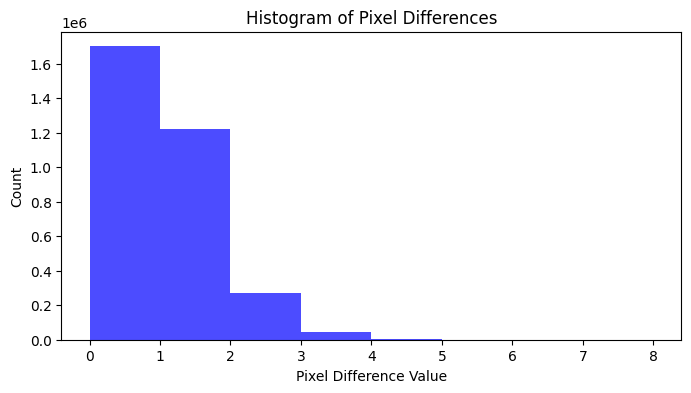

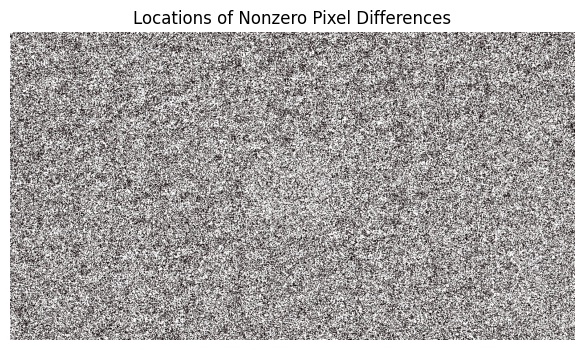

Pixel difference value counts:
  0: 1701363
  1: 1221732
  2: 271867
  3: 43541
  4: 4904
  5: 576
  6: 46
  7: 3
Coordinates of max difference (7):
[[   0  180    2]
 [   0  181    2]
 [ 725 1001    2]]


In [25]:
# Visualize and summarize the difference distribution
import matplotlib.pyplot as plt

# Flatten the difference array for histogram
flat_diff = np_diff.flatten()
plt.figure(figsize=(8,4))
plt.hist(flat_diff, bins=range(0, np.max(flat_diff)+2), color='blue', alpha=0.7)
plt.title('Histogram of Pixel Differences')
plt.xlabel('Pixel Difference Value')
plt.ylabel('Count')
plt.show()

# Show where the differences are (overlay mask)
diff_mask = np.any(np_diff > 0, axis=-1)
plt.figure(figsize=(8,4))
plt.imshow(diff_mask, cmap='hot')
plt.title('Locations of Nonzero Pixel Differences')
plt.axis('off')
plt.show()

# Print more stats
unique, counts = np.unique(flat_diff, return_counts=True)
print('Pixel difference value counts:')
for u, c in zip(unique, counts):
    print(f'  {u}: {c}')

# If you want to see a summary of where the differences are, you can also print the coordinates of the largest differences:
max_diff_coords = np.argwhere(np_diff == np.max(np_diff))
print(f'Coordinates of max difference ({np.max(np_diff)}):')
print(max_diff_coords)

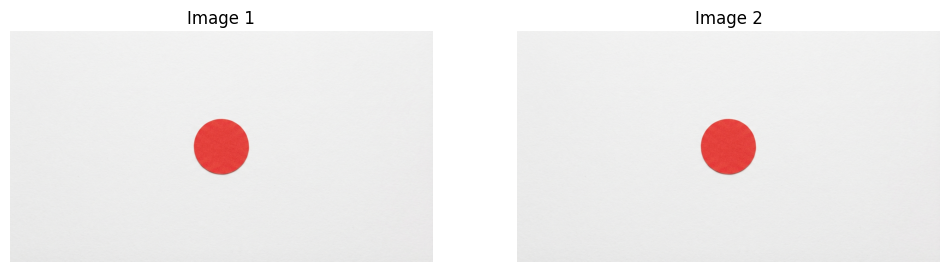

In [26]:
# Display both images side by side for visual comparison
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Image 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Image 2')
plt.axis('off')
plt.show()

In [27]:
# Utility function to compare two images with a threshold
from PIL import Image
import numpy as np

def identical_image(img_a, img_b, threshold=2.0):
    """
    Compare two PIL images. Returns True if mean pixel difference <= threshold.
    Converts images to same mode and size if needed.
    """
    if img_a.mode != img_b.mode:
        img_b = img_b.convert(img_a.mode)
    if img_a.size != img_b.size:
        img_b = img_b.resize(img_a.size)
    arr_a = np.array(img_a)
    arr_b = np.array(img_b)
    diff = np.abs(arr_a.astype(np.int16) - arr_b.astype(np.int16))
    mean_diff = np.mean(diff)
    print(f"Mean pixel difference: {mean_diff:.2f} (threshold: {threshold})")
    return mean_diff <= threshold

# Example usage:
print("Are images identical (default threshold)?", identical_image(img1, img2))
print("Are images identical (threshold=5)?", identical_image(img1, img2, threshold=5))

Mean pixel difference: 0.59 (threshold: 2.0)
Are images identical (default threshold)? True
Mean pixel difference: 0.59 (threshold: 5)
Are images identical (threshold=5)? True
